In [1]:
from time import monotonic_ns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import pycountry
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import Polygon
import cartopy.crs as ccrs

In [2]:
eur=pd.read_csv('/Users/mac/Downloads/egyetem/2025_02_ősz/KORMI1/data (1).csv')

## Filter the dataset based on the the previous notebook

In [3]:
df=eur.loc[
    ~eur.REF_AREA.isin(['HR', 'LT', 'LV', 'NL', 'I9']),
    ['KEY', 'TIME_PERIOD', 'REF_AREA', 'ACCOUNT_ENTRY', 'INSTR_ASSET', 'DWA_GRP', 'OBS_VALUE', 'UNIT_MEASURE', 'TITLE']]

In [4]:
df["TIME_PERIOD"] = pd.PeriodIndex(df["TIME_PERIOD"], freq="Q").to_timestamp()

In [5]:
df=df[df.TIME_PERIOD>'2014-09-01']

In [6]:
df

,KEY,TIME_PERIOD,REF_AREA,ACCOUNT_ENTRY,INSTR_ASSET,DWA_GRP,OBS_VALUE,UNIT_MEASURE,TITLE
16,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2014-10-01,AT,A,F2M,B50,33250.67,EUR,Deposits of households - Bottom 50% based on n...
17,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2015-01-01,AT,A,F2M,B50,33566.78,EUR,Deposits of households - Bottom 50% based on n...
18,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2015-04-01,AT,A,F2M,B50,33593.99,EUR,Deposits of households - Bottom 50% based on n...
19,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2015-07-01,AT,A,F2M,B50,33538.23,EUR,Deposits of households - Bottom 50% based on n...
20,DWA.Q.AT.S14.A.LE.F2M.B50.EUR.S.N,2015-10-01,AT,A,F2M,B50,34342.17,EUR,Deposits of households - Bottom 50% based on n...
...,...,...,...,...,...,...,...,...,...
636695,DWA.Q.SK.S14._Z._Z.NWA._Z.GI.S.N,2024-01-01,SK,_Z,NWA,_Z,56.86,GI,Gini coefficient of households
636696,DWA.Q.SK.S14._Z._Z.NWA._Z.GI.S.N,2024-04-01,SK,_Z,NWA,_Z,56.61,GI,Gini coefficient of households
636697,DWA.Q.SK.S14._Z._Z.NWA._Z.GI.S.N,2024-07-01,SK,_Z,NWA,_Z,56.36,GI,Gini coefficient of households
636698,DWA.Q.SK.S14._Z._Z.NWA._Z.GI.S.N,2024-10-01,SK,_Z,NWA,_Z,56.19,GI,Gini coefficient of households


## Get countries' border data
It's a good time to remind: do not trust on LLMs, they still say a lot of dumbs. </br>
Data is from: https://www.naturalearthdata.com/downloads/50m-cultural-vectors/

In [8]:
path='ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'
cntrs=gpd.read_file(path)[['ISO_A2_EH','geometry', 'CONTINENT']]
borders=cntrs[(cntrs.CONTINENT=='Europe')|(cntrs.ISO_A2_EH=='CY')]
borders

,ISO_A2_EH,geometry,CONTINENT
5,VA,"POLYGON ((12.439 41.898, 12.431 41.898, 12.428...",Europe
28,JE,"POLYGON ((-2.0187 49.231, -2.0099 49.181, -2.0...",Europe
29,GG,"POLYGON ((-2.5123 49.495, -2.5474 49.429, -2.6...",Europe
30,IM,"POLYGON ((-4.4121 54.185, -4.6143 54.059, -4.6...",Europe
31,GB,"MULTIPOLYGON (((-2.6677 51.623, -2.7421 51.581...",Europe
33,UA,"MULTIPOLYGON (((38.214 47.091, 38.178 47.08, 3...",Europe
47,CH,"POLYGON ((9.524 47.524, 9.5544 47.511, 9.6259 ...",Europe
48,SE,"MULTIPOLYGON (((19.076 57.836, 18.994 57.812, ...",Europe
54,ES,"MULTIPOLYGON (((1.5939 38.672, 1.5712 38.659, ...",Europe
60,SK,"POLYGON ((22.539 49.073, 22.524 49.031, 22.483...",Europe


## Start of the analysis
Mean and median

In [9]:
df.UNIT_MEASURE.unique()

array(['EUR', 'EUR_R_NH', 'EUR_R_POP', 'EUR_MD', 'EUR_MN', 'PT', 'GI'],
      dtype=object)

In [10]:
df.loc[df.UNIT_MEASURE=='EUR_MD'].TITLE.unique()

array(['Median net wealth of households'], dtype=object)

In [11]:
median_order=df[df.UNIT_MEASURE=='EUR_MD'].sort_values(by='OBS_VALUE', ascending=False).REF_AREA.unique()

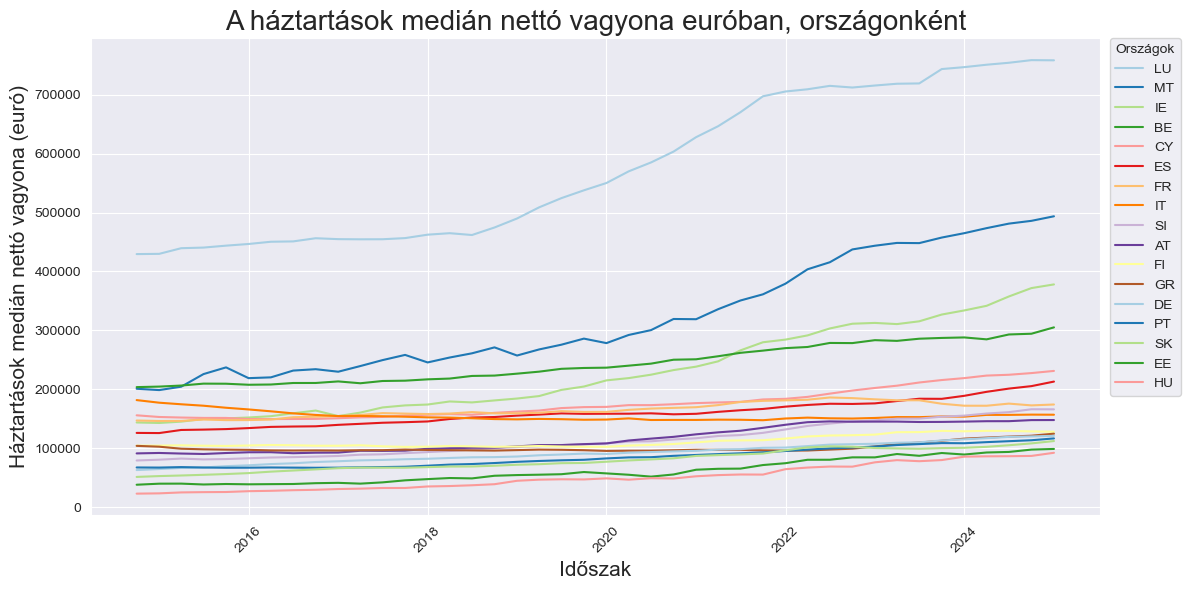

In [47]:
# median
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[df.UNIT_MEASURE=='EUR_MD'],
    x='TIME_PERIOD',
    y='OBS_VALUE',
    hue='REF_AREA',
    hue_order=median_order,
    palette='Paired',
    linewidth=1.5
)
plt.xticks(rotation=45)
plt.xlabel('Időszak', fontsize=15)
plt.ylabel('Háztartások medián nettó vagyona (euró)', fontsize=15)
plt.title('A háztartások medián nettó vagyona euróban, országonként', fontsize=20)
plt.legend(title='Országok', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

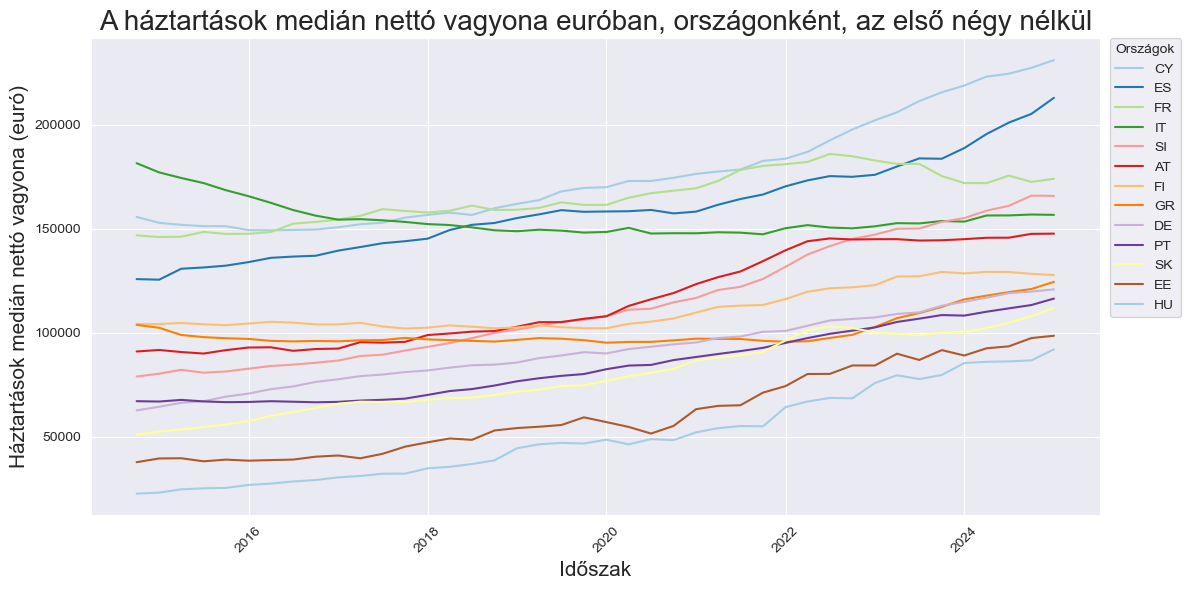

In [48]:
# median
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[(df.UNIT_MEASURE=='EUR_MD')&(~df.REF_AREA.isin(['LU','MT','IE','BE']))],
    x='TIME_PERIOD',
    y='OBS_VALUE',
    hue='REF_AREA',
    hue_order=median_order[4::],
    palette='Paired',
    linewidth=1.5
)
plt.xticks(rotation=45)
plt.xlabel('Időszak', fontsize=15)
plt.ylabel('Háztartások medián nettó vagyona (euró)', fontsize=15)
plt.title('A háztartások medián nettó vagyona euróban, országonként, az első négy nélkül', fontsize=20)
plt.legend(title='Országok', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

In [14]:
mean_order=df[df.UNIT_MEASURE=='EUR_MN'].sort_values(by='OBS_VALUE', ascending=False).REF_AREA.unique()

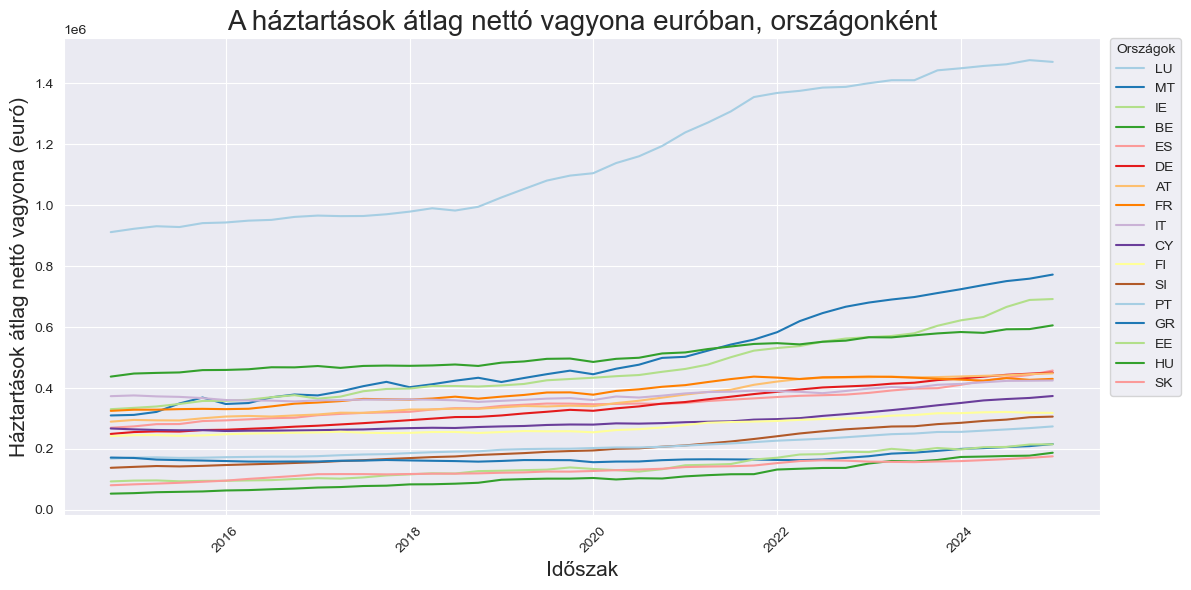

In [49]:
# mean
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[df.UNIT_MEASURE=='EUR_MN'],
    x='TIME_PERIOD',
    y='OBS_VALUE',
    hue='REF_AREA',
    hue_order=mean_order,
    palette='Paired',
    linewidth=1.5
)
plt.xticks(rotation=45)
plt.xlabel('Időszak', fontsize=15)
plt.ylabel('Háztartások átlag nettó vagyona (euró)', fontsize=15)
plt.title('A háztartások átlag nettó vagyona euróban, országonként', fontsize=20)
plt.legend(title='Országok', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

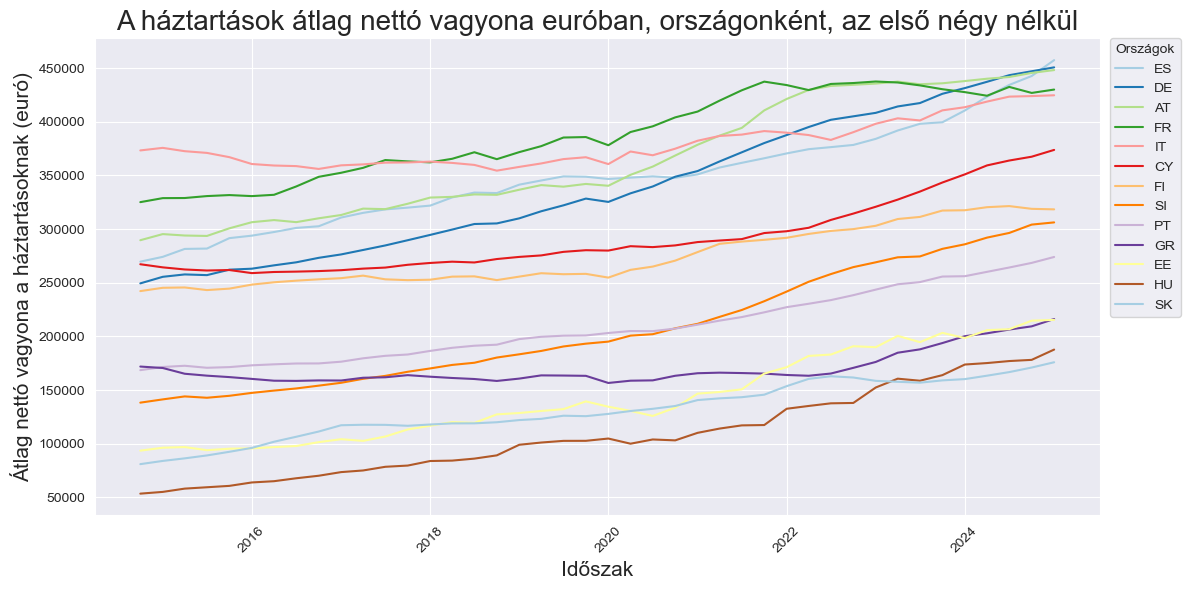

In [50]:
# mean
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[(df.UNIT_MEASURE=='EUR_MN')&(~df.REF_AREA.isin(['LU','MT','IE','BE']))],
    x='TIME_PERIOD',
    y='OBS_VALUE',
    hue='REF_AREA',
    hue_order=mean_order[4::],
    palette='Paired',
    linewidth=1.5
)
plt.xticks(rotation=45)
plt.xlabel('Időszak', fontsize=15)
plt.ylabel('Átlag nettó vagyona a háztartásoknak (euró)', fontsize=15)
plt.title('A háztartások átlag nettó vagyona euróban, országonként, az első négy nélkül', fontsize=20)
plt.legend(title='Országok', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

## Composition of the wealth
Checking the columns below, for each country just for the last quarter. Always checking the per household value to compare the DWA groups.
- ACCOUNT_ENTRY --> assets, liabilities and the difference
- INSTR_ASSET --> within asset
- DWA_GRP --> interesting for the net

### ACCOUNT_ENTRY
#### assets

In [17]:
composition=df[df.TIME_PERIOD=='2025-01-01']

In [18]:
assets=composition[(composition.ACCOUNT_ENTRY=='A')&(composition.UNIT_MEASURE=='EUR_R_NH')&
                    (composition.DWA_GRP.isin(['B50','D6','D7','D8','D9','D10']))&(composition.INSTR_ASSET!='F_NNA')]
assets_pivot=assets.pivot_table(index='REF_AREA', columns='INSTR_ASSET', values='OBS_VALUE', aggfunc='sum')
assets_pivot=assets_pivot.iloc[assets_pivot.sum(axis=1).argsort()]

In [19]:
custom_labels = [
    'Nettó lakásvagyon',                            # NUN
    'Nem pénzügyi üzleti vagyon',                   # NUB
    'Életbiztosítási és járadékjogosultságok',      # F62
    'Befektetési alapok részvényei/egységei',       # F52
    'Nem jegyzett részvények és egyéb tőkeelemek',  # F51M
    'Tőzsdén jegyzett részvények',                  # F511
    'Kötvények',                                    # F3
    'Betétek'                                       # F2M
]

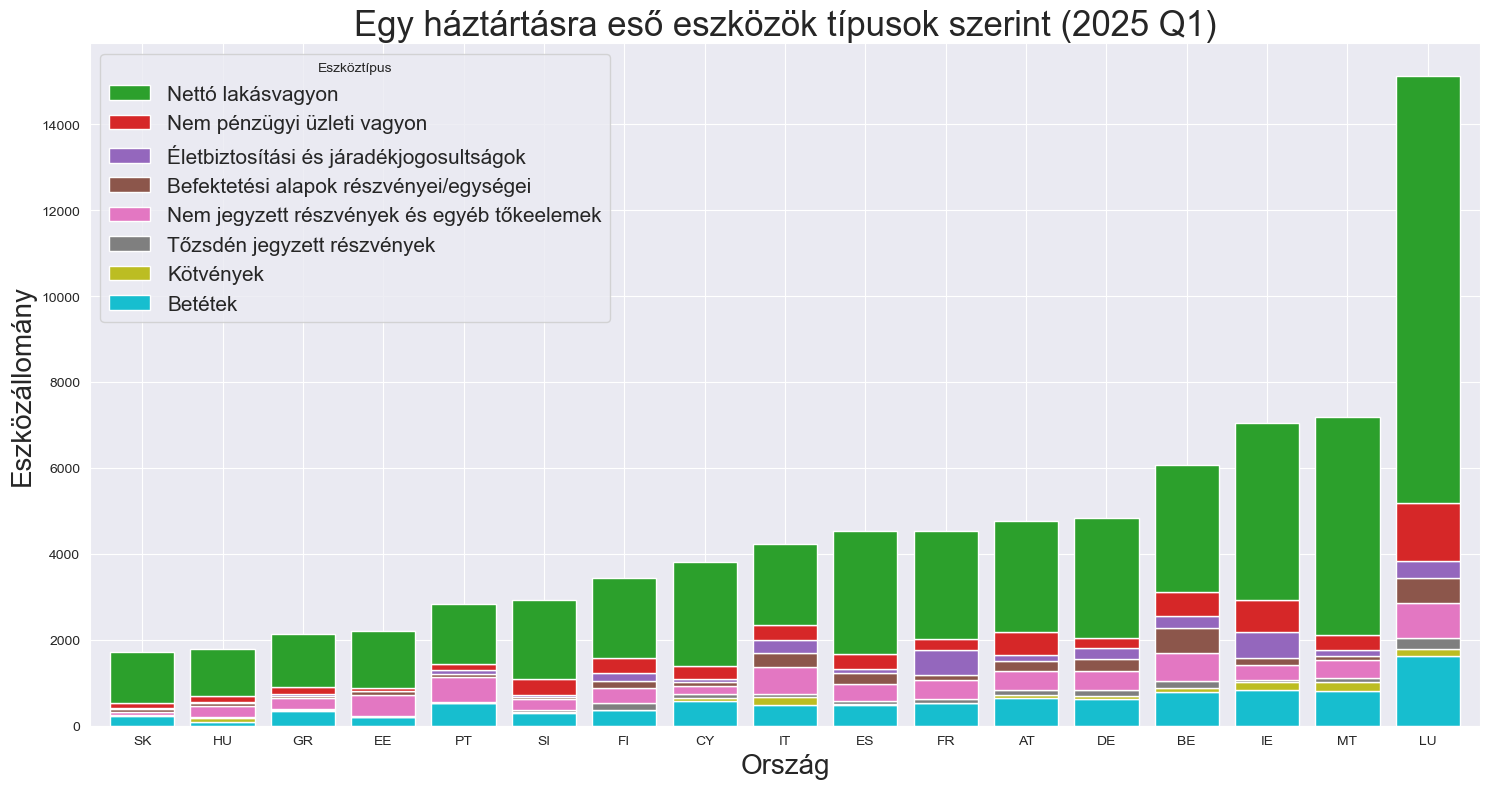

In [43]:
cmap = plt.get_cmap("tab10_r")
colors = [cmap(i) for i in range(len(assets_pivot.columns))]
ax = assets_pivot.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("Egy háztártásra eső eszközök típusok szerint (2025 Q1)", fontsize=25)
plt.ylabel("Eszközállomány", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1], title="Eszköztípus", loc='upper left',labels=custom_labels, fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
assets_pivot_percent = assets_pivot.div(assets_pivot.sum(axis=1), axis=0)

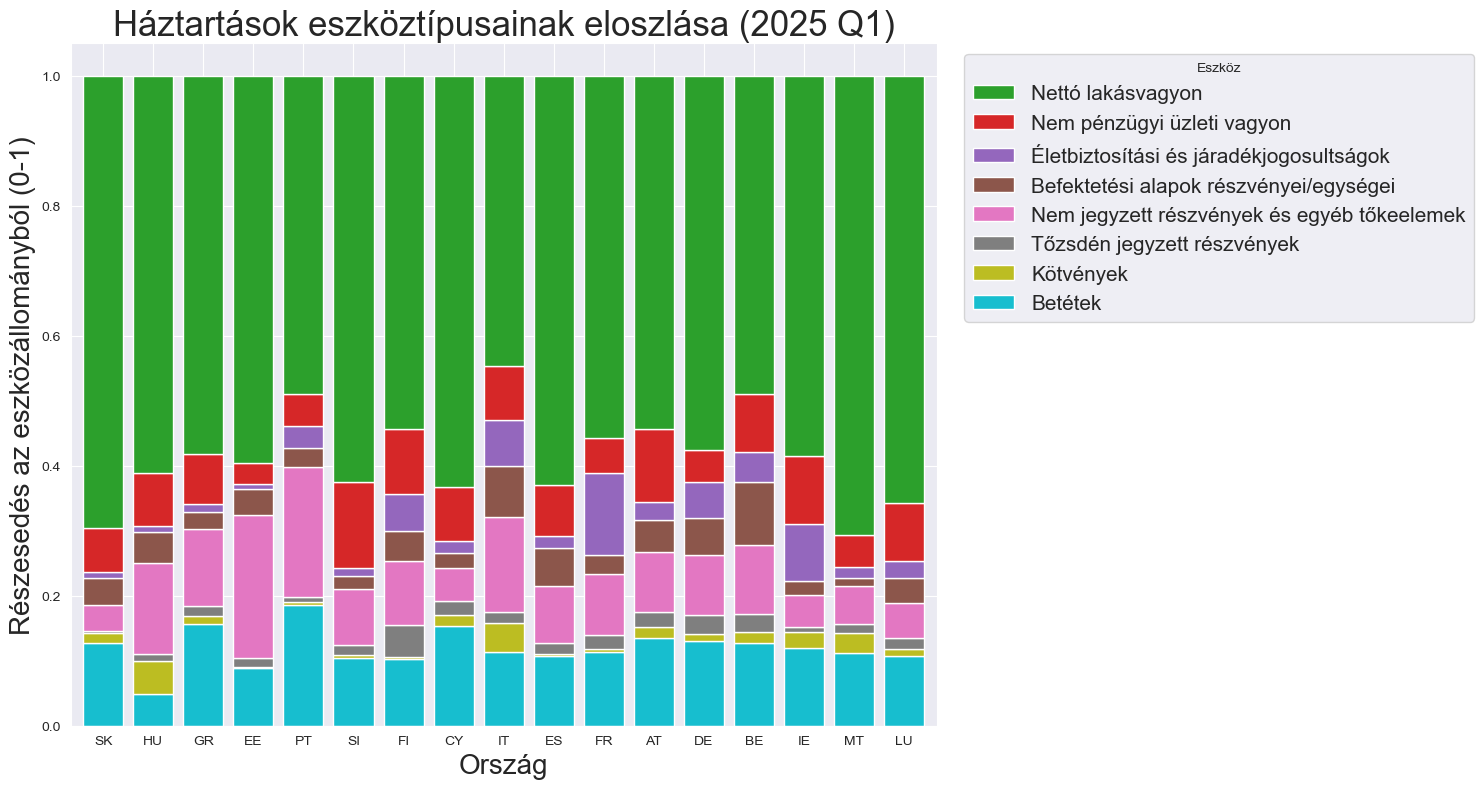

In [51]:
cmap = plt.get_cmap("tab10_r")
colors = [cmap(i) for i in range(len(assets_pivot.columns))]
ax = assets_pivot_percent.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("Háztartások eszköztípusainak eloszlása (2025 Q1)", fontsize=25)
plt.ylabel("Részesedés az eszközállományból (0-1)", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1],title="Eszköz", bbox_to_anchor=(1.02, 1), loc='upper left', labels=custom_labels, fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Liabilities

In [23]:
liabilities=composition[(composition.ACCOUNT_ENTRY=='L')&(composition.UNIT_MEASURE=='EUR_R_NH')&
                          (composition.DWA_GRP.isin(['B50','D6','D7','D8','D9','D10']))&(composition.INSTR_ASSET!='F_NNA')]
liabilities_pivot=liabilities.pivot_table(index='REF_AREA', columns='INSTR_ASSET', values='OBS_VALUE', aggfunc='sum')
liabilities_pivot=liabilities_pivot.iloc[liabilities_pivot.sum(axis=1).argsort()]
# liabilities_pivot=liabilities_pivot[['B50','D6','D7','D8','D9','D10']]

In [24]:
custom_labels2 = [
    'Lakásvásárláson kívüli hitelek',   # F4X
    'Lakásvásárlási hitelek'           # F4B
]

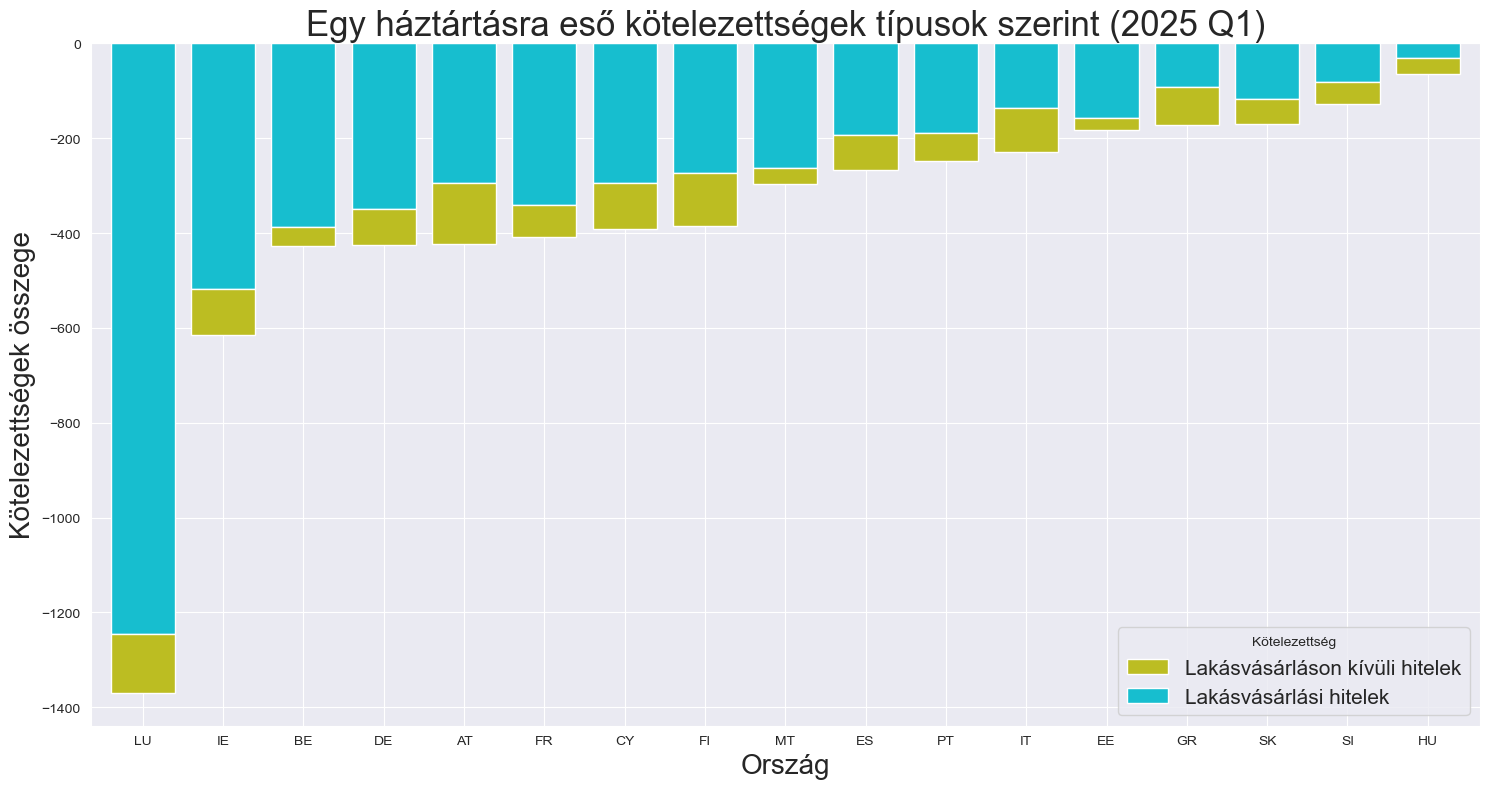

In [52]:
cmap = plt.get_cmap("tab10_r")
colors = [cmap(i) for i in range(len(assets_pivot.columns))]
ax = liabilities_pivot.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("Egy háztártásra eső kötelezettségek típusok szerint (2025 Q1)", fontsize=25)
plt.ylabel("Kötelezettségek összege", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1], title="Kötelezettség", loc='lower right', labels=custom_labels2, fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
liabilities_pivot_percent = liabilities_pivot.div(liabilities_pivot.sum(axis=1), axis=0)

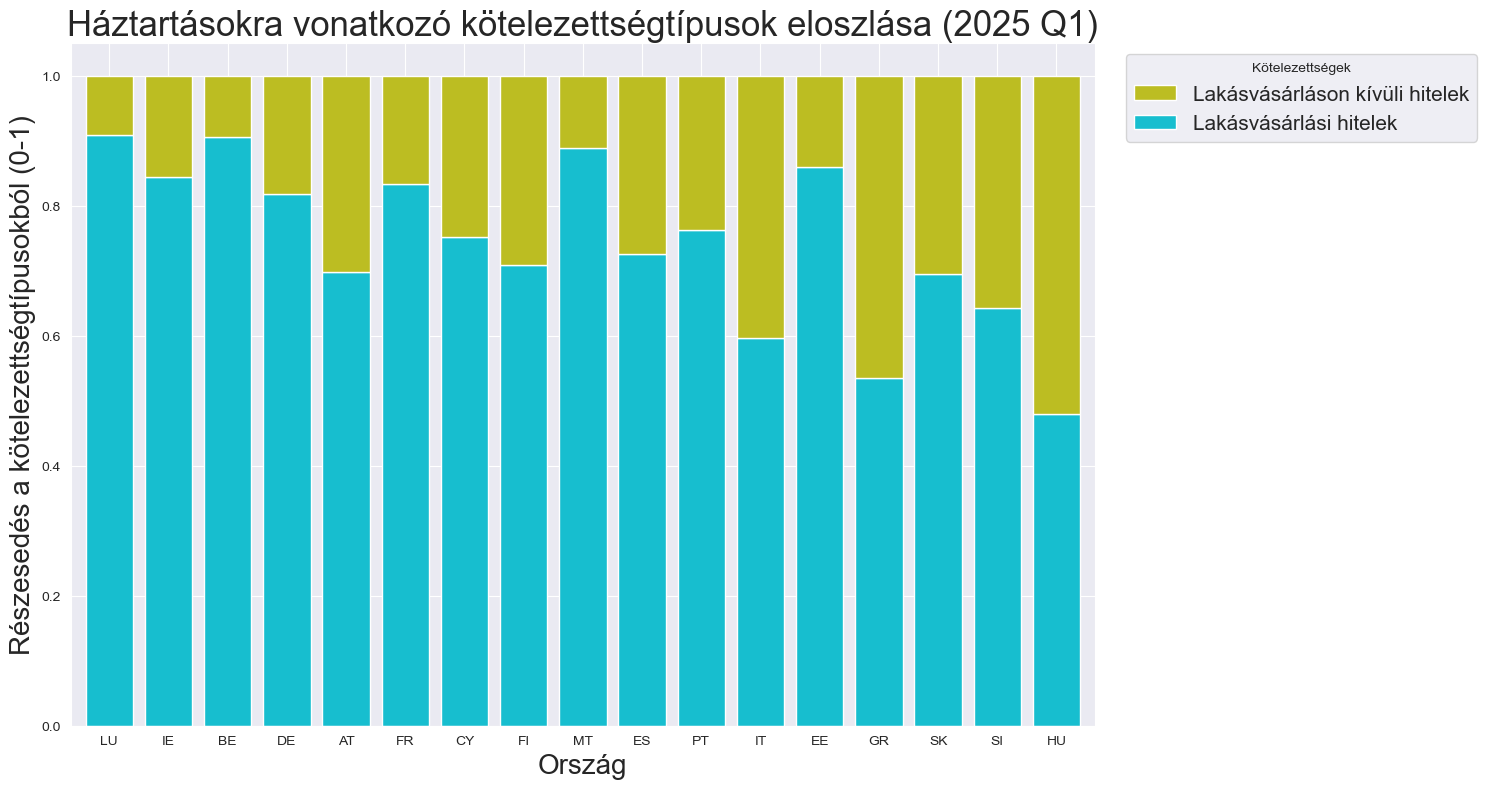

In [54]:
cmap = plt.get_cmap("tab10_r")
colors = [cmap(i) for i in range(len(assets_pivot.columns))]
ax = liabilities_pivot_percent.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("Háztartásokra vonatkozó kötelezettségtípusok eloszlása (2025 Q1)", fontsize=25)
plt.ylabel("Részesedés a kötelezettségtípusokból (0-1)", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1], title="Kötelezettségek", bbox_to_anchor=(1.02, 1), loc='upper left', labels=custom_labels2, fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Net

In [28]:
accounts_diff=composition[(composition.ACCOUNT_ENTRY=='N')&(composition.UNIT_MEASURE=='EUR_R_NH')&
                          (composition.DWA_GRP.isin(['B50','D6','D7','D8','D9','D10']))]
accounts_pivot=accounts_diff.pivot(index='REF_AREA', columns='DWA_GRP', values='OBS_VALUE')
accounts_pivot=accounts_pivot[['D10', 'D9', 'D8', 'D7', 'D6', 'B50']]
accounts_pivot = accounts_pivot.iloc[accounts_pivot.sum(axis=1).argsort()]

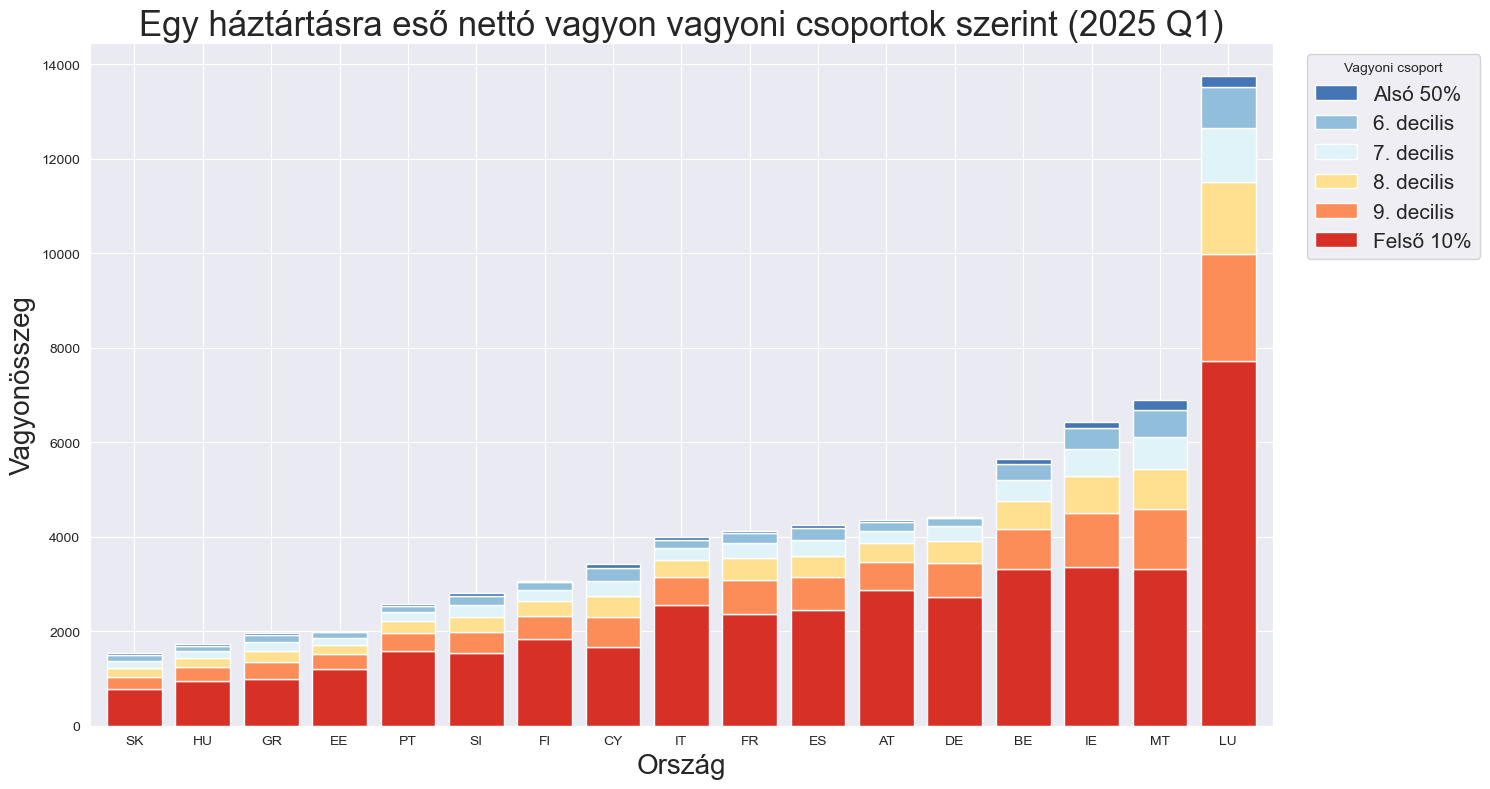

In [55]:
colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
ax = accounts_pivot.plot(kind='bar', stacked=True, figsize=(15, 8), color=colors, width=0.8)
handles, _ = ax.get_legend_handles_labels()
plt.title("Egy háztártásra eső nettó vagyon vagyoni csoportok szerint (2025 Q1)", fontsize=25)
plt.ylabel("Vagyonösszeg", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1], title="Vagyoni csoport", bbox_to_anchor=(1.02, 1), loc='upper left', labels=['Alsó 50%', '6. decilis', '7. decilis', '8. decilis', '9. decilis', 'Felső 10%'], fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
accounts_pivot_percent = accounts_pivot.div(accounts_pivot.sum(axis=1), axis=0)

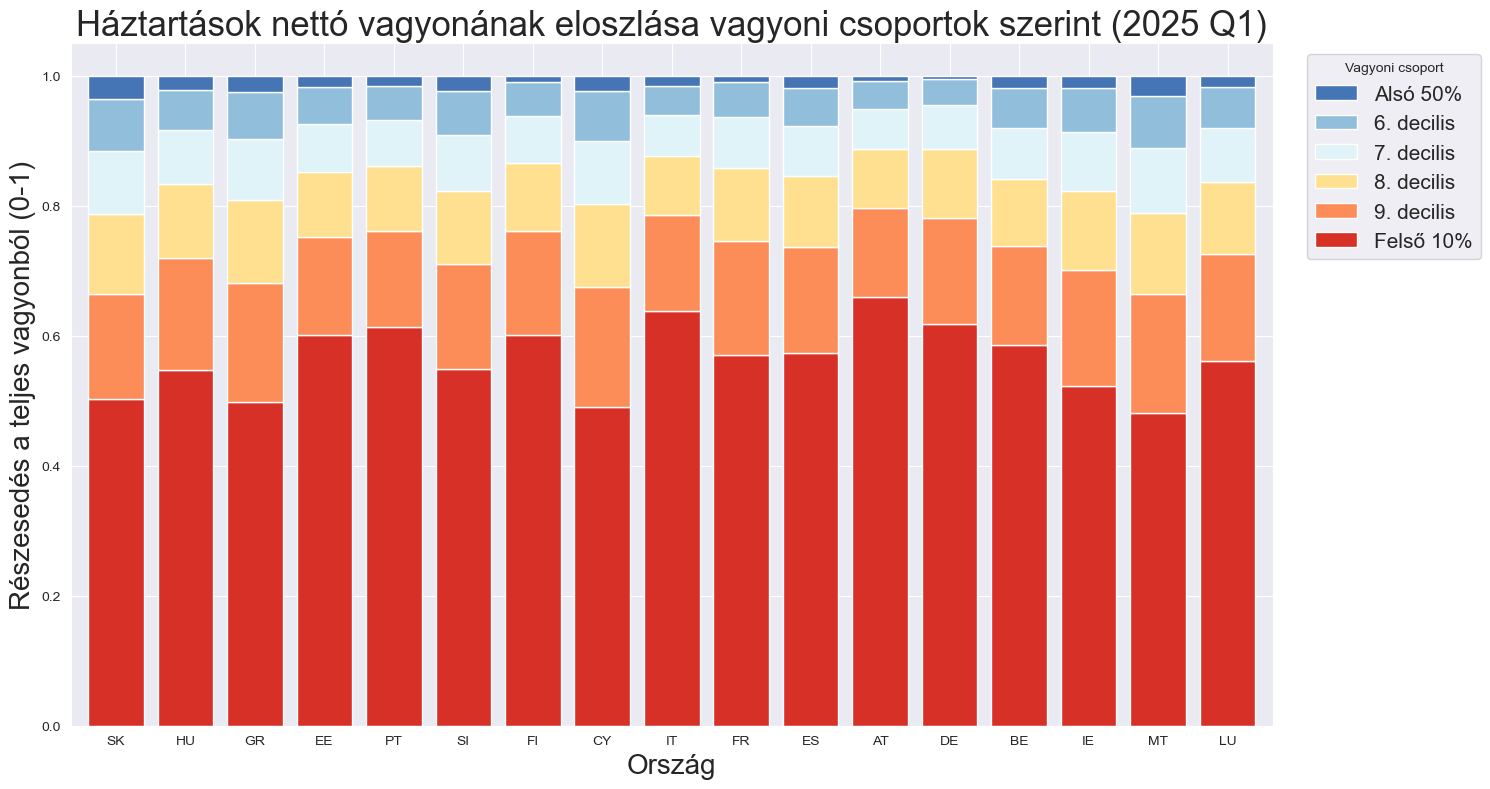

In [58]:
colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
ax = accounts_pivot_percent.plot(kind='bar', stacked=True, figsize=(15, 8), color=colors, width=0.8)
handles, _ = ax.get_legend_handles_labels()
plt.title("Háztartások nettó vagyonának eloszlása vagyoni csoportok szerint (2025 Q1)", fontsize=25)
plt.ylabel("Részesedés a teljes vagyonból (0-1)", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1], title="Vagyoni csoport", bbox_to_anchor=(1.02, 1), loc='upper left', labels=['Alsó 50%', '6. decilis', '7. decilis', '8. decilis', '9. decilis', 'Felső 10%'], fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Measure the inequality

In [60]:
gini=df[df.TITLE.str.contains('Gini')]

In [61]:
gini_order=gini[gini.TIME_PERIOD=='2025-01-01'].sort_values(by='OBS_VALUE', ascending=False).REF_AREA.unique()

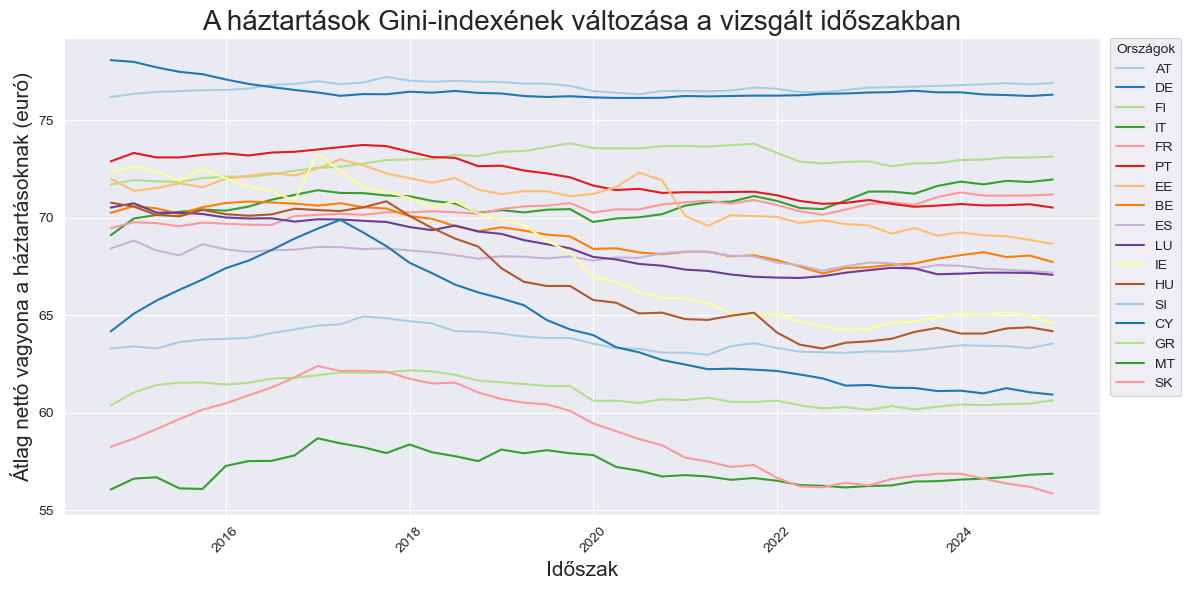

In [64]:
# mean
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[df.TITLE.str.contains('Gini')],
    x='TIME_PERIOD',
    y='OBS_VALUE',
    hue='REF_AREA',
    hue_order=gini_order,
    palette='Paired',
    linewidth=1.5
)
plt.xticks(rotation=45)
plt.xlabel('Időszak', fontsize=15)
plt.ylabel('Átlag nettó vagyona a háztartásoknak (euró)', fontsize=15)
plt.title('A háztartások Gini-indexének változása a vizsgált időszakban', fontsize=20)
plt.legend(title='Országok', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

In [65]:
gini=df[df.TITLE.str.contains('Gini')]
gini=pd.merge(gini, borders, left_on='REF_AREA', right_on='ISO_A2_EH', how='right')

In [66]:
gini.REF_AREA.unique()

array([nan, 'ES', 'SK', 'SI', 'PT', 'MT', 'LU', 'IT', 'IE', 'HU', 'GR',
       'DE', 'FR', 'FI', 'EE', 'CY', 'BE', 'AT'], dtype=object)

In [67]:
gini=gpd.GeoDataFrame(gini).to_crs(4326)

In [68]:
# Rough continental Europe polygon
europe_poly = Polygon([
    (-11, 30),   # SW
    (-11, 72),   # NW
    (37, 72),  # NE, extended east to include Cyprus
    (37, 30)   # SE, extended east
])

clipper = gpd.GeoDataFrame(geometry=[europe_poly], crs=gini.crs)
gini = gpd.overlay(gini, clipper, how='intersection')

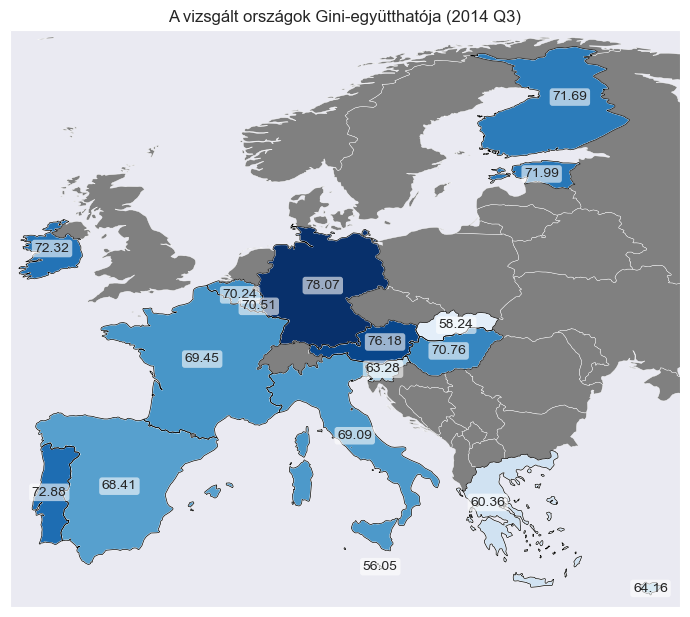

In [74]:
projection = ccrs.LambertCylindrical()
fig, ax = plt.subplots(figsize=(7, 9), subplot_kw={'projection': projection})
gdf = gini[gini.TIME_PERIOD == '2014-10-01'].dissolve(by='REF_AREA', aggfunc='first')

gdf.plot(column='OBS_VALUE',ax=ax,cmap='Blues',legend=False,transform=ccrs.PlateCarree())
gdf.boundary.plot(ax=ax, color='black', linewidth=0.5, transform=ccrs.PlateCarree())
gini[gini.OBS_VALUE.isna()].plot(ax=ax, linewidth=0.3, color='grey', transform=ccrs.PlateCarree())

for idx, row in gdf.iterrows():
    lon, lat = row.geometry.representative_point().coords[0]
    x, y = projection.transform_point(lon, lat, src_crs=ccrs.PlateCarree())
    ax.text(x, y, f"{row['OBS_VALUE']:.2f}",fontsize=10,ha='center',va='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2'))
ax.set_extent([-11, 35, 34, 72], crs=ccrs.PlateCarree())
plt.title("A vizsgált országok Gini-együtthatója (2014 Q3)")
plt.tight_layout()
plt.show()

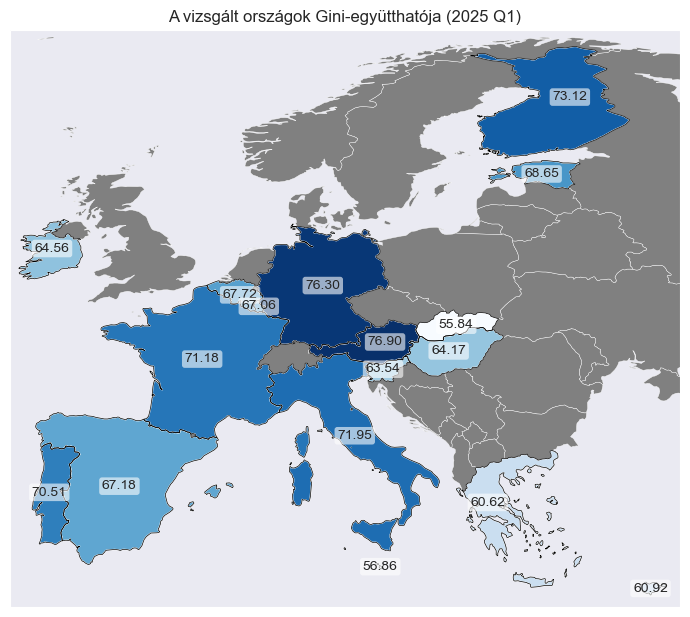

In [73]:
projection = ccrs.LambertCylindrical()
fig, ax = plt.subplots(figsize=(7, 9), subplot_kw={'projection': projection})
gdf = gini[gini.TIME_PERIOD == '2025-01-01'].dissolve(by='REF_AREA', aggfunc='first')

gdf.plot(column='OBS_VALUE',ax=ax,cmap='Blues',legend=False,transform=ccrs.PlateCarree())
gdf.boundary.plot(ax=ax, color='black', linewidth=0.5, transform=ccrs.PlateCarree())
gini[gini.OBS_VALUE.isna()].plot(ax=ax, linewidth=0.3, color='grey', transform=ccrs.PlateCarree())

for idx, row in gdf.iterrows():
    lon, lat = row.geometry.representative_point().coords[0]
    x, y = projection.transform_point(lon, lat, src_crs=ccrs.PlateCarree())
    ax.text(x, y, f"{row['OBS_VALUE']:.2f}",fontsize=10,ha='center',va='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2'))
ax.set_extent([-11, 35, 34, 72], crs=ccrs.PlateCarree())
plt.title("A vizsgált országok Gini-együtthatója (2025 Q1)")
plt.tight_layout()
plt.show()

In [39]:
gini_diff=gini[gini.TIME_PERIOD.isin(['2014-10-01','2025-01-01'])].groupby(['REF_AREA', 'geometry'])['OBS_VALUE'].agg(lambda x: x.iloc[-1] - x.iloc[0]).reset_index()

/var/folders/cs/xp5ntzyj1vd_s71rmnfnf3xw0000gn/T/ipykernel_35613/3789239216.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  gini_diff=gini[gini.TIME_PERIOD.isin(['2014-10-01','2025-01-01'])].groupby(['REF_AREA', 'geometry'])['OBS_VALUE'].agg(lambda x: x.iloc[-1] - x.iloc[0]).reset_index()


In [76]:
gini_diff=gpd.GeoDataFrame(gini_diff).dissolve(by='REF_AREA', aggfunc='first')

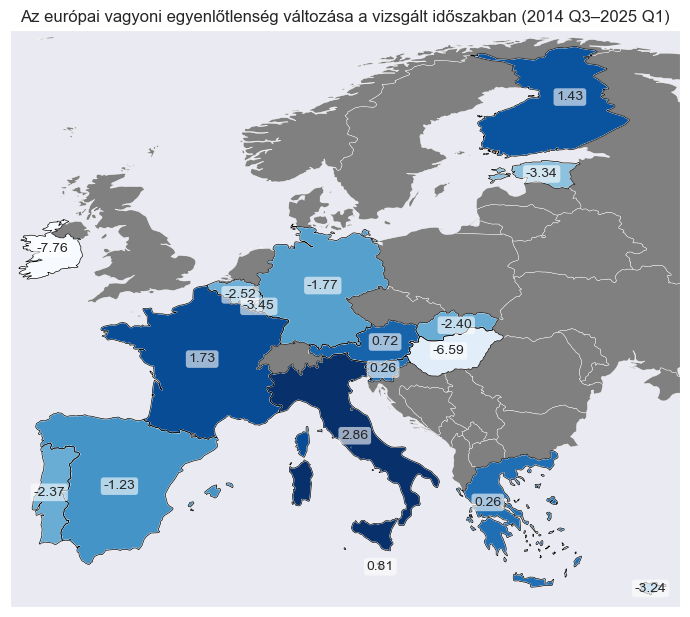

In [77]:
projection = ccrs.LambertCylindrical()
fig, ax = plt.subplots(figsize=(7, 9), subplot_kw={'projection': projection})
gdf = gini_diff.reset_index()

gdf.plot(column='OBS_VALUE',ax=ax,cmap='Blues',legend=False,transform=ccrs.PlateCarree())
gdf.boundary.plot(ax=ax, color='black', linewidth=0.5, transform=ccrs.PlateCarree())
gini[gini.OBS_VALUE.isna()].plot(ax=ax, linewidth=0.3, color='grey', transform=ccrs.PlateCarree())

for idx, row in gdf.iterrows():
    lon, lat = row.geometry.representative_point().coords[0]
    x, y = projection.transform_point(lon, lat, src_crs=ccrs.PlateCarree())
    ax.text(x, y, f"{row['OBS_VALUE']:.2f}",fontsize=10,ha='center',va='center',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2'))
ax.set_extent([-11, 35, 34, 72], crs=ccrs.PlateCarree())
plt.title("Az európai vagyoni egyenlőtlenség változása a vizsgált időszakban (2014 Q3–2025 Q1)")
plt.tight_layout()
plt.show()

## Who owns the gotten wealth?
### All wealth

In [79]:
money=df[(df.ACCOUNT_ENTRY=='N')&(df.UNIT_MEASURE=='EUR_R_NH')&(df.TIME_PERIOD.isin(['2025-01-01', '2014-10-01']))&
         (df.DWA_GRP.isin(['B50','D6','D7','D8','D9','D10']))]

/var/folders/cs/xp5ntzyj1vd_s71rmnfnf3xw0000gn/T/ipykernel_35613/3907122709.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  money=df[(df.ACCOUNT_ENTRY=='N')&(df.UNIT_MEASURE=='EUR_R_NH')&(df.TIME_PERIOD.isin(['2025-01-01', '2014-10-01']))&


In [80]:
new_money=money.groupby(['REF_AREA', 'DWA_GRP'])['OBS_VALUE'].agg(lambda x: x.iloc[-1] - x.iloc[0]).reset_index()
new_money=new_money.pivot_table(index='REF_AREA',columns='DWA_GRP',values='OBS_VALUE',aggfunc='sum')
new_money=new_money[['B50','D6','D7','D8','D9','D10']]
new_money = new_money.iloc[new_money.sum(axis=1).argsort()]


In [81]:
new_money

DWA_GRP,B50,D6,D7,D8,D9,D10
REF_AREA,,,,,,
GR,13.23,18.65,26.91,41.39,53.68,236.18
IT,4.65,-30.51,-27.87,-12.39,56.63,500.38
FI,5.48,27.28,42.00,64.89,111.01,489.53
SK,32.00,66.88,80.27,101.29,132.50,409.50
CY,36.64,79.18,94.44,115.59,143.14,453.08
PT,19.95,56.00,73.71,96.50,141.72,586.48
FR,5.56,37.43,69.25,107.81,166.54,638.42
EE,24.26,67.01,87.11,116.06,166.84,659.78
HU,30.23,79.55,106.22,146.55,219.02,638.87


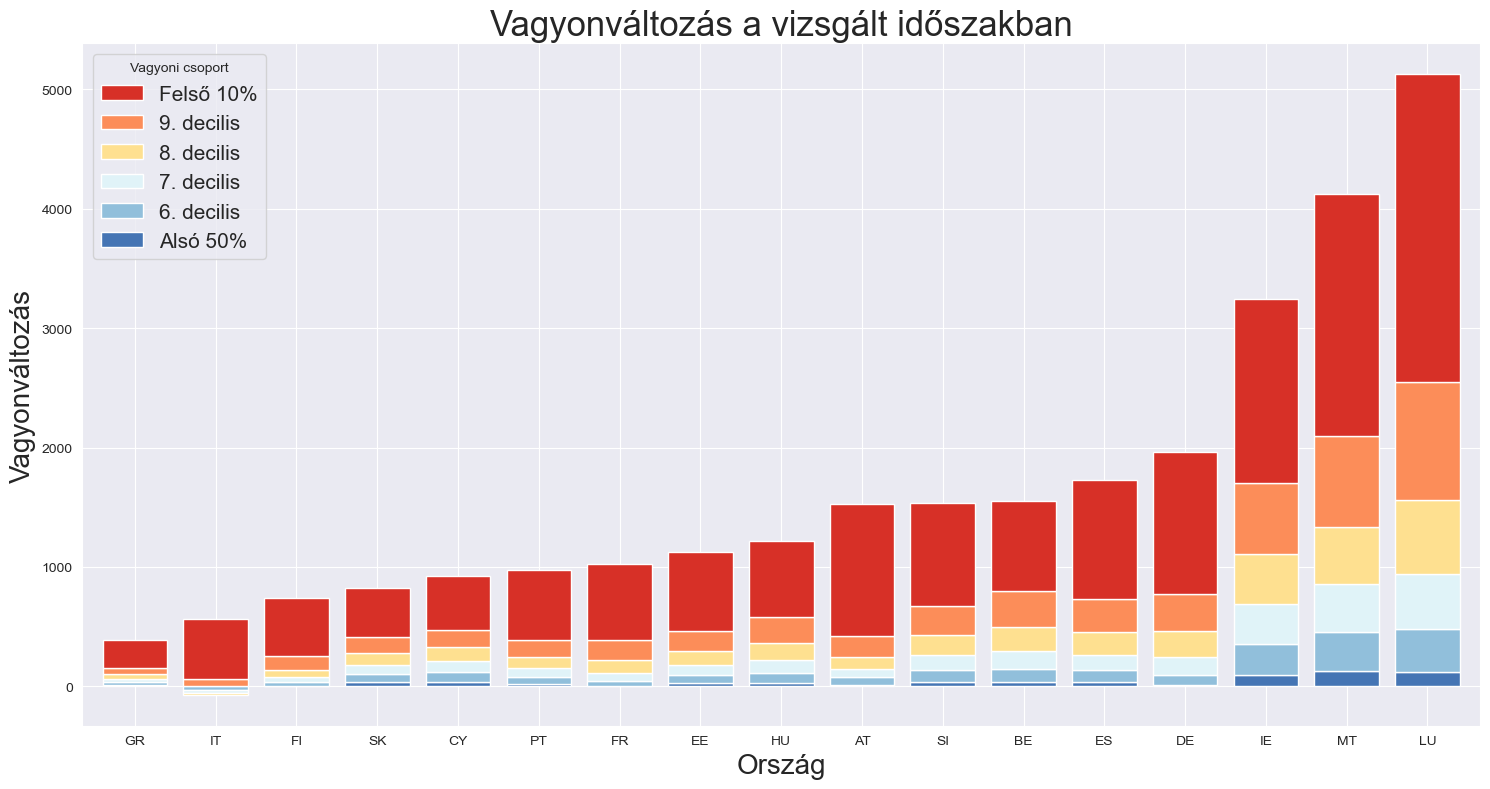

In [82]:
colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
ax = new_money.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("Vagyonváltozás a vizsgált időszakban", fontsize=25)
plt.ylabel("Vagyonváltozás", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1], title="Vagyoni csoport", loc='upper left',labels=['Felső 10%', '9. decilis', '8. decilis', '7. decilis', '6. decilis', 'Alsó 50%'], fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [84]:
new_money_percent = new_money.div(abs(new_money).sum(axis=1), axis=0)

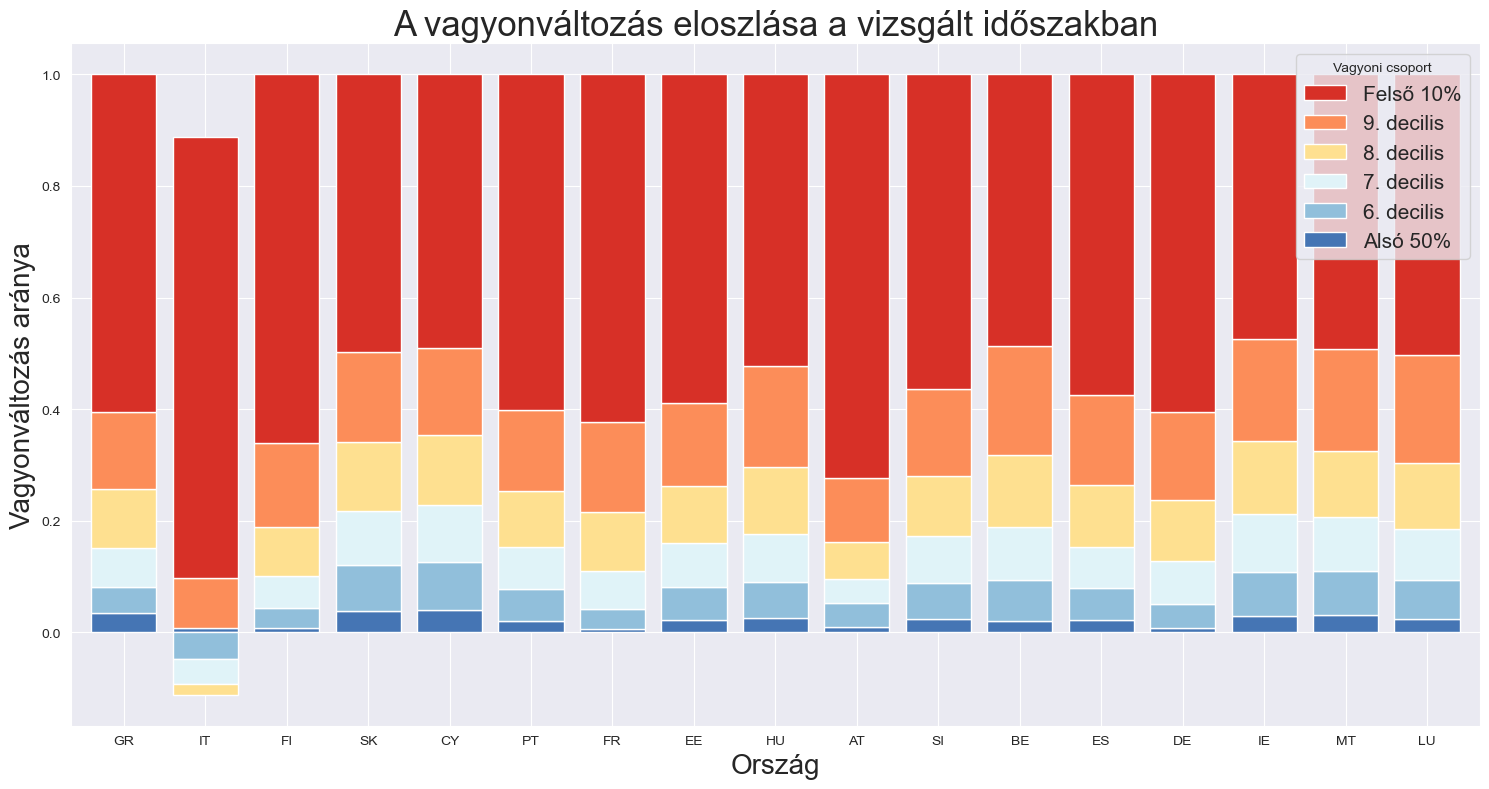

In [85]:
colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
ax = new_money_percent.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("A vagyonváltozás eloszlása a vizsgált időszakban", fontsize=25)
plt.ylabel("Vagyonváltozás aránya", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1], title="Vagyoni csoport", loc='upper right',labels=['Felső 10%', '9. decilis', '8. decilis', '7. decilis', '6. decilis', 'Alsó 50%'], fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Household savings

In [90]:
nonun=df[(df.ACCOUNT_ENTRY=='A')&(df.UNIT_MEASURE=='EUR_R_NH')&(df.INSTR_ASSET.isin(['F2M', 'F3','F511', 'F52', 'F62']))
         &(df.TIME_PERIOD.isin(['2025-01-01', '2014-10-01']))&(df.DWA_GRP.isin(['B50','D6','D7','D8','D9','D10']))]

/var/folders/cs/xp5ntzyj1vd_s71rmnfnf3xw0000gn/T/ipykernel_35613/4030556411.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  &(df.TIME_PERIOD.isin(['2025-01-01', '2014-10-01']))&(df.DWA_GRP.isin(['B50','D6','D7','D8','D9','D10']))]


In [91]:
nonun=nonun.groupby(['REF_AREA', 'DWA_GRP','TIME_PERIOD'])['OBS_VALUE'].sum().reset_index()
nononun=nonun.groupby(['REF_AREA', 'DWA_GRP'])['OBS_VALUE'].agg(lambda x: x.iloc[-1] - x.iloc[0]).reset_index()
nononun=nononun.pivot_table(index='REF_AREA',columns='DWA_GRP',values='OBS_VALUE',aggfunc='sum')
nononun=nononun[['B50','D6','D7','D8','D9','D10']]
nononun = nononun.iloc[nononun.sum(axis=1).argsort()]

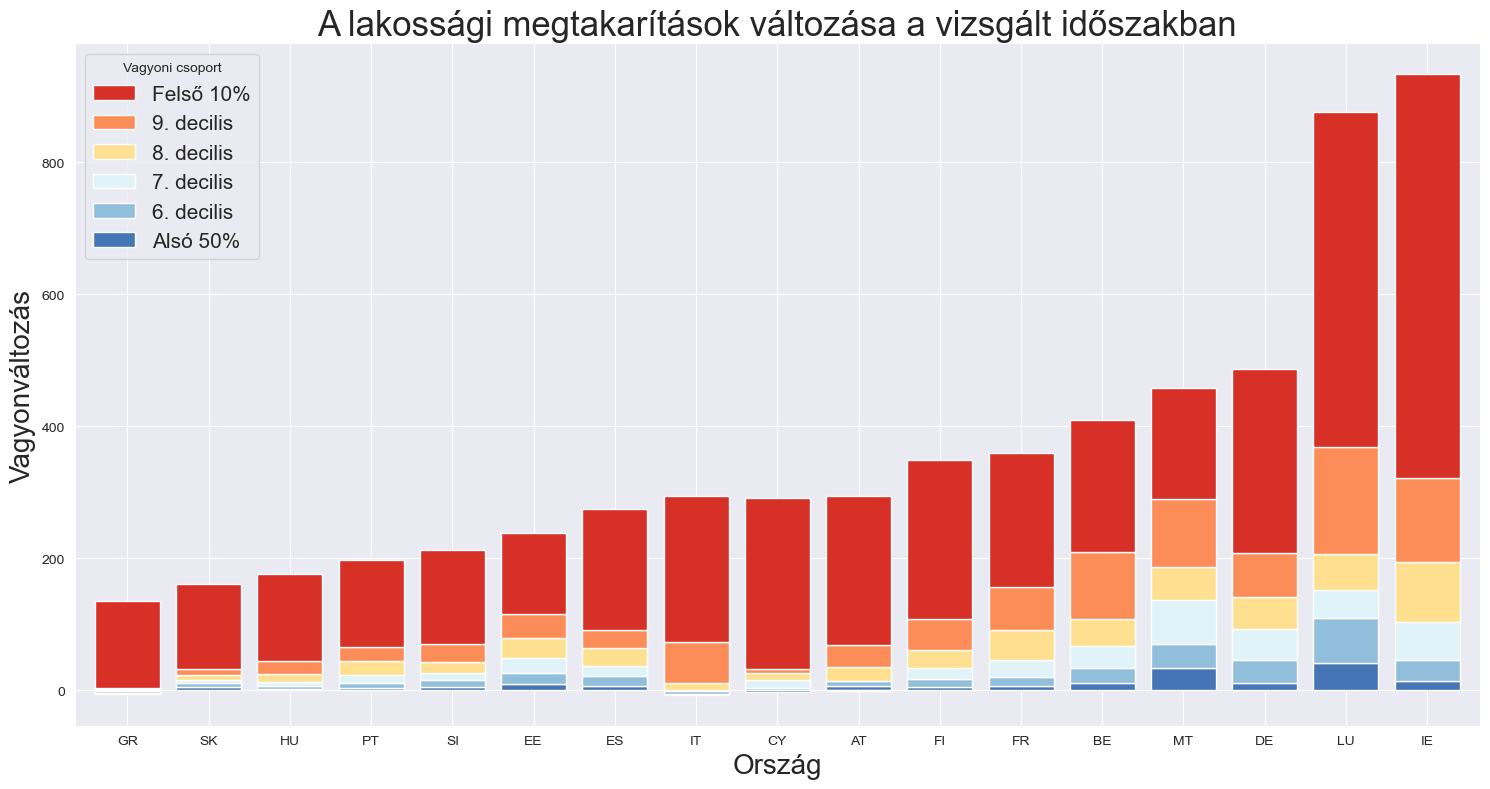

In [95]:
colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
ax = nononun.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("A lakossági megtakarítások változása a vizsgált időszakban", fontsize=25)
plt.ylabel("Vagyonváltozás", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1], title="Vagyoni csoport", loc='upper left',labels=['Felső 10%', '9. decilis', '8. decilis', '7. decilis', '6. decilis', 'Alsó 50%'], fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [93]:
nononun_percent = nononun.div(abs(nononun).sum(axis=1), axis=0)

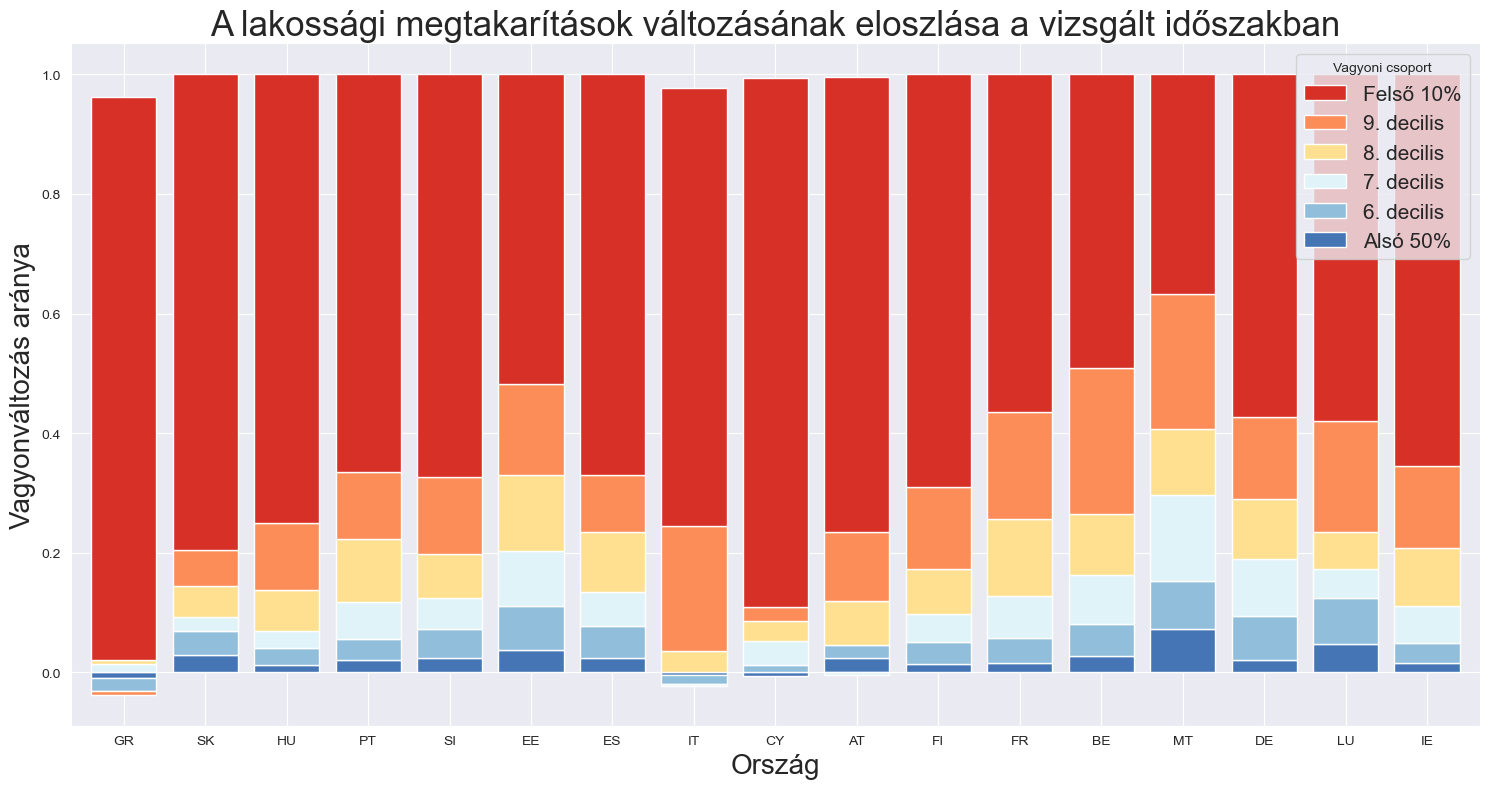

In [94]:
colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
ax = nononun_percent.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8,color=colors)
handles, _ = ax.get_legend_handles_labels()
plt.title("A lakossági megtakarítások változásának eloszlása a vizsgált időszakban", fontsize=25)
plt.ylabel("Vagyonváltozás aránya", fontsize=20)
plt.xlabel("Ország", fontsize=20)
plt.legend(handles=handles[::-1], title="Vagyoni csoport", loc='upper right',labels=['Felső 10%', '9. decilis', '8. decilis', '7. decilis', '6. decilis', 'Alsó 50%'], fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()